In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
from PIL import Image
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

from model.siamese_koch2015 import *
from trainer.train_v1 import *
from trainer.process_data import *

print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'CUDA device: {torch.cuda.get_device_name(0)}')

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Hyperparameters
BATCH_SIZE = 32
EMBEDDING_DIM = 4096
NUM_EPOCHS = 50
SUBSET_SIZE = 131280 # Number of cats per epoch
PAIRS_PER_EPOCH = 200000

# Dataset paths
DATASET_PATH = './cat'  # Adjust this to your actual path
ANNOTATION_PATH = './annotation'

print(f'Batch size: {BATCH_SIZE}')
print(f'Embedding dimension: {EMBEDDING_DIM}')
print(f'Training epochs: {NUM_EPOCHS}')

Using device: cuda
Batch size: 32
Embedding dimension: 4096
Training epochs: 50


In [3]:
# Load image paths and labels
image_paths, labels = load_cat_data('./cat')


Loading data from: ./cat
Found 164100 cat folders


Loading cats: 100%|██████████| 164100/164100 [00:13<00:00, 12312.10it/s]


Loaded 643539 images from 164100 unique cats


In [4]:
# Get unique cat IDs
unique_cats = sorted(list(set(labels)))
print(f'Total unique cats: {len(unique_cats)}')

# Split CAT IDs (not images!)
train_cat_ids, val_cat_ids = train_test_split(
    unique_cats, 
    test_size=0.2, 
    random_state=42
)

# Convert to sets for fast lookup
train_cat_ids = set(train_cat_ids)
val_cat_ids = set(val_cat_ids)

print(f'Train cats: {len(train_cat_ids)}')
print(f'Val cats: {len(val_cat_ids)}')

# Split images based on cat ID assignment
train_paths, train_labels = [], []
val_paths, val_labels = [], []

for img_path, cat_id in zip(image_paths, labels):
    if cat_id in train_cat_ids:
        train_paths.append(img_path)
        train_labels.append(cat_id)
    else:
        val_paths.append(img_path)
        val_labels.append(cat_id)

print(f'\nTraining images: {len(train_paths)}')
print(f'Validation images: {len(val_paths)}')
print(f'Training cats: {len(set(train_labels))}')
print(f'Validation cats: {len(set(val_labels))}')


Total unique cats: 164100
Train cats: 131280
Val cats: 32820

Training images: 515159
Validation images: 128380
Training cats: 131280
Validation cats: 32820


In [5]:
train_transform = get_paper_transforms()

# Datasets
train_dataset = CatPairDataset(
    train_paths, train_labels, train_transform,
    subset_size=SUBSET_SIZE,
    pairs_per_epoch=PAIRS_PER_EPOCH
)

val_dataset = CatPairDataset(
    val_paths, val_labels, train_transform,
    subset_size=1000,
    pairs_per_epoch=5000
)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f'Train batches: {len(train_loader)}')
print(f'Val batches: {len(val_loader)}')

Total cats: 131280
Total images: 515159
Generated 100000 positive and 100000 negative pairs
Total cats: 32820
Total images: 128380
Generated 2500 positive and 2500 negative pairs
Train batches: 6250
Val batches: 157


In [6]:
model = Siamese(embedding_dim=EMBEDDING_DIM)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print(f'Model size: {total_params * 4 / 1024 / 1024:.2f} MB')

trainer = Trainer(model, device)

Total parameters: 38,964,545
Trainable parameters: 38,964,545
Model size: 148.64 MB
DEVICE USING: cuda


In [ ]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
patience = 20
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}')
    print('-' * 60)
    
    # Train
    train_loss, train_acc = trainer.train_epoch(train_loader, epoch)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    
    # Early stopping check
    if train_acc > best_val_acc:
        best_val_acc = train_acc
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_cat_siamese_model.pth')
        print(f'New best accuracy: {best_val_acc:.2f}% - Model saved!')
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch+1} epochs')
        break

print('\nTraining completed!')


Epoch 1/50
------------------------------------------------------------


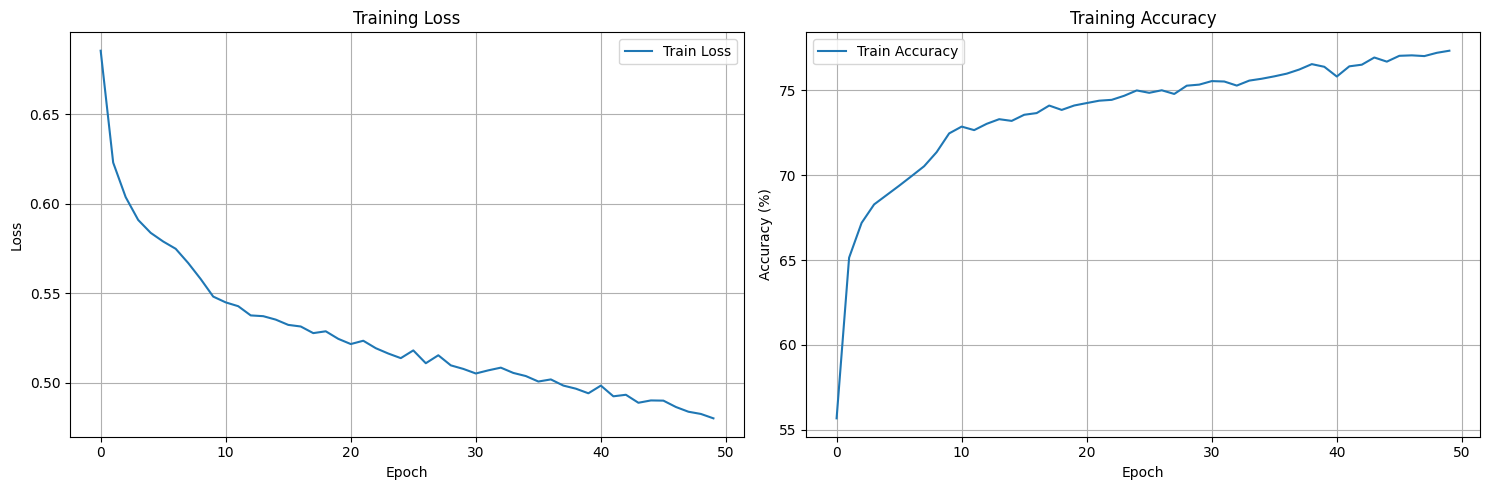

Training plots saved as training_history.png


In [ ]:
# plotting the training history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(history['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print('Training plots saved as training_history.png')

In [ ]:
# Load best model
model.load_state_dict(torch.load('best_cat_siamese_model.pth'))
model.eval()

# Test with a sample pair
with torch.no_grad():
    # Get a batch from validation
    img1, img2, labels = next(iter(val_loader))
    img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
    
    outputs = model(img1, img2)
    predictions = (outputs.squeeze() > 0.5).float()
    
    accuracy = (predictions == labels).float().mean().item()
    
    print(f'Test batch accuracy: {accuracy * 100:.2f}%')
    print(f'Sample predictions: {predictions[:10].cpu().numpy()}')
    print(f'Sample labels: {labels[:10].cpu().numpy()}')

Test batch accuracy: 34.38%
Sample predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample labels: [1. 0. 1. 1. 0. 1. 1. 0. 0. 0.]


In [ ]:
# Save training history
import json

with open('training_history.json', 'w') as f:
    json.dump(history, f, indent=4)

print('Training history saved to training_history.json')
print('\nFinal Results:')
print(f'Best training accuracy: {max(history["train_acc"]):.2f}%')
print(f'Final training loss: {history["train_loss"][-1]:.6f}')

Training history saved to training_history.json

Final Results:
Best training accuracy: 77.33%
Final training loss: 0.480042
